##### Copyright 2020 The IREE Authors

In [1]:
#@title Licensed under the Apache License v2.0 with LLVM Exceptions.
# See https://llvm.org/LICENSE.txt for license information.
# SPDX-License-Identifier: Apache-2.0 WITH LLVM-exception

# Image edge detection module

## Setup

In [2]:
%%capture
!python -m pip install --upgrade tf-nightly  # Needed for stablehlo export in TF>=2.14

In [3]:
!python -m pip install iree-compiler iree-runtime iree-tools-tf -f https://openxla.github.io/iree/pip-release-links.html

Looking in links: https://openxla.github.io/iree/pip-release-links.html


In [4]:
#@title Imports

import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from iree import runtime as ireert
from iree.tf.support import module_utils
from iree.compiler import compile_str
from iree.compiler import tf as tfc

# Print version information for future notebook users to reference.
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.15.0-dev20230831


In [5]:
#@title Setup Artifacts Directory

# Used in the low-level compilation section.
ARTIFACTS_DIR = os.path.join(tempfile.gettempdir(), "iree", "colab_artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

In [6]:
#@title Define the EdgeDetectionModule
class EdgeDetectionModule(tf.Module):

  @tf.function(input_signature=[tf.TensorSpec([1, 128, 128, 1], tf.float32)])
  def edge_detect_sobel_operator(self, image):
    # https://en.wikipedia.org/wiki/Sobel_operator
    sobel_x = tf.constant([[-1.0, 0.0, 1.0],
                           [-2.0, 0.0, 2.0],
                           [-1.0, 0.0, 1.0]],
                          dtype=tf.float32, shape=[3, 3, 1, 1])
    sobel_y = tf.constant([[ 1.0,  2.0,  1.0],
                           [ 0.0,  0.0,  0.0],
                           [-1.0, -2.0, -1.0]],
                          dtype=tf.float32, shape=[3, 3, 1, 1])
    gx = tf.nn.conv2d(image, sobel_x, 1, "SAME")
    gy = tf.nn.conv2d(image, sobel_y, 1, "SAME")
    return tf.math.sqrt(gx * gx + gy * gy)

tf_module = EdgeDetectionModule()

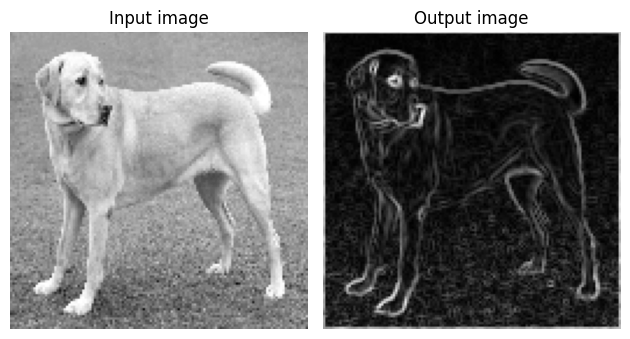

In [7]:
#@title Load a test image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) and run the module with TF
def load_image(path_to_image):
  image = tf.io.read_file(path_to_image)
  image = tf.image.decode_image(image, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (128, 128))
  image = image[tf.newaxis, :]
  return image

content_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image = load_image(content_path).numpy()

def show_images(image, edges):
  fig, axs = plt.subplots(1, 2)

  axs[0].imshow(image.reshape(128, 128), cmap="gray")
  axs[0].set_title("Input image")
  axs[1].imshow(edges.reshape(128, 128), cmap="gray")
  axs[1].set_title("Output image")

  axs[0].axis("off")
  axs[1].axis("off")
  fig.tight_layout()
  fig.show()

# Invoke the function with the image as an argument
tf_edges = tf_module.edge_detect_sobel_operator(image).numpy()

# Plot the input and output images
show_images(image, tf_edges)

## High Level Compilation With IREE

In [8]:
#@markdown ### Backend Configuration

backend_choice = "iree_vmvx (CPU)" #@param [ "iree_vmvx (CPU)", "iree_llvmcpu (CPU)", "iree_vulkan (GPU/SwiftShader)" ]
backend_choice = backend_choice.split(" ")[0]
backend = module_utils.BackendInfo(backend_choice)

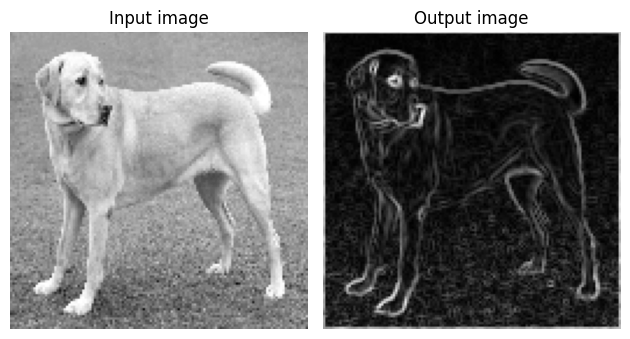

In [9]:
#@title Compile and Run the EdgeDetectionModule with IREE.
module = backend.compile_from_class(EdgeDetectionModule)

# Compute the edges using the compiled module and display the result.
iree_edges = module.edge_detect_sobel_operator(image)
show_images(image, iree_edges)

## Low-Level Compilation

Overview:

1.  Convert the `tf.Module` into an IREE compiler module (using `stablehlo`)
2.  Save the MLIR assembly from the module into a file (can stop here to use it from another application)
3.  Compile the `stablehlo` MLIR into a VM module for IREE to execute
4.  Run the VM module through IREE's runtime to test the edge detection function

In [11]:
#@title Construct a module containing the edge detection function

# Do *not* further compile to a bytecode module for a particular backend.
#
# By stopping at stablehlo, we can more easily take advantage of future
# compiler improvements within IREE. For a production application, we would
# probably want to freeze the version of IREE used and compile as completely as
# possible ahead of time, then use some other scheme to load the module into
# the application at runtime.
compiler_module = tfc.compile_module(
    EdgeDetectionModule(), import_only=True)

# Save the imported MLIR to disk.
imported_mlirbc_path = os.path.join(ARTIFACTS_DIR, "edge_detection.mlirbc")
with open(imported_mlirbc_path, "wb") as output_file:
  output_file.write(compiler_module)
print(f"Wrote MLIR to path '{imported_mlirbc_path}'")

# Copy MLIR bytecode to MLIR text and see how the compiler views this program.
imported_mlir_path = os.path.join(ARTIFACTS_DIR, "edge_detection.mlir")
!iree-ir-tool copy {imported_mlirbc_path} -o {imported_mlir_path}
print("Edge Detection MLIR:")
!cat {imported_mlir_path}

Wrote MLIR to path '/tmp/iree/colab_artifacts/edge_detection.mlirbc'
Edge Detection MLIR:
module {
  func.func @edge_detect_sobel_operator(%arg0: tensor<1x128x128x1xf32>) -> tensor<1x128x128x1xf32> {
    %0 = stablehlo.constant dense<[[[[-1.000000e+00]], [[0.000000e+00]], [[1.000000e+00]]], [[[-2.000000e+00]], [[0.000000e+00]], [[2.000000e+00]]], [[[-1.000000e+00]], [[0.000000e+00]], [[1.000000e+00]]]]> : tensor<3x3x1x1xf32>
    %1 = stablehlo.constant dense<[[[[1.000000e+00]], [[2.000000e+00]], [[1.000000e+00]]], [[[0.000000e+00]], [[0.000000e+00]], [[0.000000e+00]]], [[[-1.000000e+00]], [[-2.000000e+00]], [[-1.000000e+00]]]]> : tensor<3x3x1x1xf32>
    %2 = stablehlo.convolution(%arg0, %0) dim_numbers = [b, 0, 1, f]x[0, 1, i, o]->[b, 0, 1, f], window = {stride = [1, 1], pad = [[1, 1], [1, 1]], rhs_dilate = [1, 1]} {batch_group_count = 1 : i64, feature_group_count = 1 : i64, precision_config = [#stablehlo<precision DEFAULT>, #stablehlo<precision DEFAULT>]} : (tensor<1x128x128x1xf32>, t

In [12]:
#@title Compile and prepare to test the edge detection module

flatbuffer_blob = compile_str(compiler_module, target_backends=["vmvx"], input_type="stablehlo")

# Register the module with a runtime context.
config = ireert.Config(backend.driver)
ctx = ireert.SystemContext(config=config)
vm_module = ireert.VmModule.from_flatbuffer(ctx.instance, flatbuffer_blob)
ctx.add_vm_module(vm_module)

<ipython-input-12-4d337c62f971>:8: UserWarning: Making copy of unaligned VmModule buffer. It is recommended to make this deterministic by calling `copy_buffer` to always make a copy or `mmap` to efficiently load from a file. This warning can be silenced by adding `warn_if_copy=False` to `from_buffer`
  vm_module = ireert.VmModule.from_flatbuffer(ctx.instance, flatbuffer_blob)


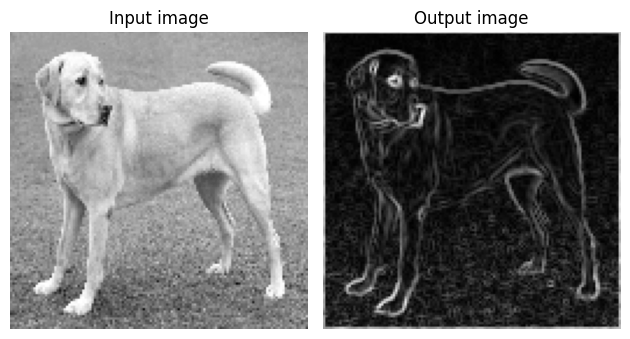

In [13]:
edge_detect_sobel_operator_f = ctx.modules.module["edge_detect_sobel_operator"]

low_level_iree_edges = edge_detect_sobel_operator_f(image)

show_images(image, low_level_iree_edges)